In [128]:
from pathlib import Path

import torch
import numpy as np
from torchvision import models
from sklearn.manifold import TSNE

from cuticulus.datasets import RoughSmoothFull
from cuticulus.console import console

In [129]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set()

In [130]:
device = torch.device("cuda:4")

In [131]:
class ResNet101(models.ResNet):
    def __init__(self, pretrained=True):
        super().__init__(
            block=models.resnet.Bottleneck,
            layers = [3, 4, 23, 3],
            num_classes=2,
        )
        if pretrained:
            model = torch.load(
                Path('./output/models/model.pt'),
                map_location=torch.device("cuda:4")
            )
            self.load_state_dict(model.state_dict())
            
    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Notice there is no forward pass through the original classifier.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

In [132]:
class TorchDS(torch.utils.data.Dataset):
    """Torch dataset class for ant image dataset."""

    def __init__(self, imgs: np.ndarray, labels: np.ndarray):
        """Initialize dataset.

        Args:
            imgs (np.ndarray): List of data.
            labels (np.ndarray): List of labels.
        """
        self.imgs = imgs
        self.labels = labels

    def __len__(self) -> int:
        """Return length of dataset.

        Returns:
            int: Length of dataset.
        """
        return len(self.imgs)

    def __getitem__(self, idx) -> tuple:
        """Return item at index idx.

        Returns:
            tuple: Tuple of image and label.
        """
        return self.imgs[idx], self.labels[idx]

In [133]:
ds = RoughSmoothFull((256, 256))
ds.images = ds.images.transpose(0, 3, 1, 2)
ds.images = ds.images.astype(np.float32)
print(ds.images.shape, ds.labels.shape)

[12:48:48] Loaded labels.                                                       ]8;id=3701;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=772677;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#89\89]8;;\

           Loaded dataset.                                                     ]8;id=59242;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=666984;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#114\114]8;;\

           Unique images considered: 2499                                      ]8;id=916469;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=403308;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#135\135]8;;\

           Samples per class:                                                  ]8;id=682726;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=520402;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#128\128]8;;\

           0: 1072                                                             ]8;id=657340;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=385636;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           1: 1427                                                             ]8;id=579718;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=800568;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

(2499, 3, 256, 256) (2499,)


In [134]:
model = ResNet101()
device = torch.device("cuda:4")
model.to(device)

ResNet101(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [135]:
data_loader = torch.utils.data.DataLoader(
    dataset=TorchDS(ds.images, ds.labels),
    batch_size=16,
    shuffle=False
)

res_images = []
res_labels = []
for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    res_images.append(outputs.cpu().detach().numpy())
    res_labels.append(labels.cpu().detach().numpy())

res_images = np.concatenate(res_images, axis=0)
res_labels = np.concatenate(res_labels, axis=0)

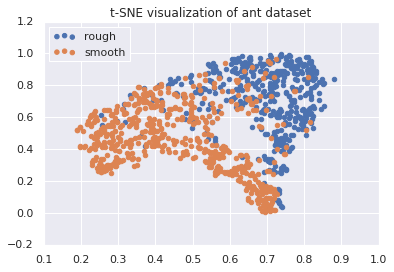

In [138]:
tsne = TSNE(n_components=2).fit_transform(res_images)
# normalize to [0, 1]
tsne = (tsne - tsne.min()) / (tsne.max() - tsne.min())

# plot the simplified dataset
fig, ax = plt.subplots()
label_map = {
    0: 'rough',
    1: 'smooth',
}

# randomly subsample to avoid overplotting
idx = np.random.choice(tsne.shape[0], size=1000, replace=False)
tsne = tsne[idx]
tsne_labels = res_labels[idx]

for label in [0, 1]:
    idx = np.where(tsne_labels == label)[0]
    ax.scatter(tsne[idx, 0], tsne[idx, 1], label=label_map[label], color=sns.color_palette()[label])

ax.set_title('t-SNE visualization of ant dataset')
ax.legend(loc='best')

plt.show()